In [34]:
!tar xvzf '/content/drive/MyDrive/cifar-100-python.tar.gz'

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


In [32]:
import torch
import numpy as np
import os
torch.manual_seed(100)
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
train = pd.read_pickle('/content/cifar-100-python/train')
dtrain = pd.DataFrame.from_dict(train, orient='index')
dtrain = dtrain.T

In [36]:
test = pd.read_pickle('/content/cifar-100-python/test')
dtest = pd.DataFrame.from_dict(test, orient='index')
dtest = dtest.T

In [37]:
meta = pd.read_pickle('/content/cifar-100-python/meta')
dmeta = pd.DataFrame.from_dict(meta, orient='index')
dmeta = dmeta.T

In [38]:
labels = list(pd.read_pickle('/content/cifar-100-python/meta')['fine_label_names'])

In [39]:
labels_idx = {v:k for (k,v) in enumerate(labels)}
idx_labels = {k:v for (k,v) in enumerate(labels)}

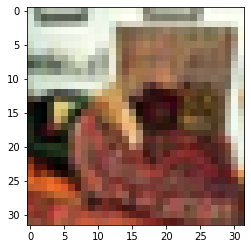

In [46]:
img = np.array(dtrain[dtrain['fine_labels'] == 25].iloc[10]['data']).reshape(3,32,32)
plt.imshow(img.transpose(1,2,0).astype("uint8"), interpolation='nearest')

In [129]:
features_train = np.array((np.stack(dtrain['data'].values, axis=0)).reshape(len(dtrain['data'].values), 3072)/255).astype('float32')
labels_train = np.array(dtrain['fine_labels'].values).astype('int64')

In [130]:
features_test = np.array((np.stack(dtest['data'].values, axis=0)).reshape(len(dtest['data'].values), 3072)/255).astype('float32')
labels_test = np.array(dtest['fine_labels'].values).astype('int64')

In [131]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, RandomHorizontalFlip, RandomVerticalFlip
import matplotlib.pyplot as plt

class CustomImageDataset(Dataset):
    def __init__(self, imgs, lbs, transform=None, target_transform=None):

        self.transform = transform
        self.target_transform = target_transform 
        self.images = imgs
        self.labels = lbs

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [132]:
from torchvision import transforms, utils

train_transform = transforms.Compose([ ToTensor(),
                                      transforms.Resize(48)])

test_transform = transforms.Compose([ ToTensor(),  transforms.Resize(48)])
                              #transforms.RandomAffine((0,90)),  RandomHorizontalFlip(0.5),
                              #])
training_data = CustomImageDataset(
    imgs = features_train, 
    lbs = labels_train
)

test_data = CustomImageDataset(
    imgs = features_test, 
    lbs = labels_test
)



In [133]:
training_data.images.shape

(50000, 3072)

In [134]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [135]:
from torch import nn

In [144]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Dropout(0,2),
            nn.Linear(512, 100),

        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [145]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [146]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=2)
    (3): Linear(in_features=512, out_features=100, bias=True)
  )
)


In [147]:
loss_fn = nn.CrossEntropyLoss()

In [148]:
learning_rate = 1e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [149]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Получаем предсказания модели для данного батча
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [150]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [151]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn)
    #test_loop(train_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.644485  [    0/50000]
loss: 4.308714  [ 6400/50000]
loss: 4.243946  [12800/50000]
loss: 4.272116  [19200/50000]
loss: 3.902598  [25600/50000]
loss: 3.703589  [32000/50000]
loss: 3.853667  [38400/50000]
loss: 3.706582  [44800/50000]
Test Error: 
 Accuracy: 11.3%, Avg loss: 3.830873 

Epoch 2
-------------------------------
loss: 3.695048  [    0/50000]
loss: 3.763915  [ 6400/50000]
loss: 3.718596  [12800/50000]
loss: 3.679045  [19200/50000]
loss: 3.957357  [25600/50000]
loss: 3.851039  [32000/50000]
loss: 3.436349  [38400/50000]
loss: 3.421137  [44800/50000]
Test Error: 
 Accuracy: 13.9%, Avg loss: 3.711710 

Epoch 3
-------------------------------
loss: 3.746388  [    0/50000]
loss: 3.754768  [ 6400/50000]
loss: 3.125389  [12800/50000]
loss: 3.856167  [19200/50000]
loss: 4.004077  [25600/50000]
loss: 3.671296  [32000/50000]
loss: 3.452407  [38400/50000]
loss: 3.521866  [44800/50000]
Test Error: 
 Accuracy: 15.4%, Avg loss: 3.650307 

Epoc

In [152]:
checkpoint_filename = "my_model.pt"
torch.save(model.state_dict(), checkpoint_filename)

Best 20.3%